# RFM Analysis on Online-Retail Dataset

In [1]:
# Import libraries needed for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import ipympl
import seaborn as sns
from scipy import stats
import numpy as np


# Import libraries needed for Clustering  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Read the dataset

The Online-Retail dataset from the UCI Machine Learning Repository contains information regaring online transactions made in a company from 01/12/2010 and 09/12/2011.

In [2]:
# Read the data on which analysis needs to be done and display first 5 entries
data='Online Retail.xlsx'
df_retail=pd.read_excel(data)
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

For the purpose of RFM analysis, we only require the customer ID, number of items and its unit price, number of transactions and the date of order. 

In [3]:
# Displays datatype, number of non null values and general properties of fields
df_retail.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We can see that number of non null values in customer ID and Description is lower than the rest of the columns, thus there exists null values in both. For puropses of customer segmentation, description is not relevant and hence the entries with null values for it need not be removed. 

In [4]:
# Number of null entries in customer ID
print("The number of null entries for CustomerID is : {}".format(df_retail['CustomerID'].isna().sum()))

The number of null entries for CustomerID is : 135080


In [5]:
# Checks the number of duplicates
print("The number of duplicate entries : {}".format(df_retail.duplicated().sum())) 

The number of duplicate entries : 5268


The country wise distribution can be helpful to further filter out data. 

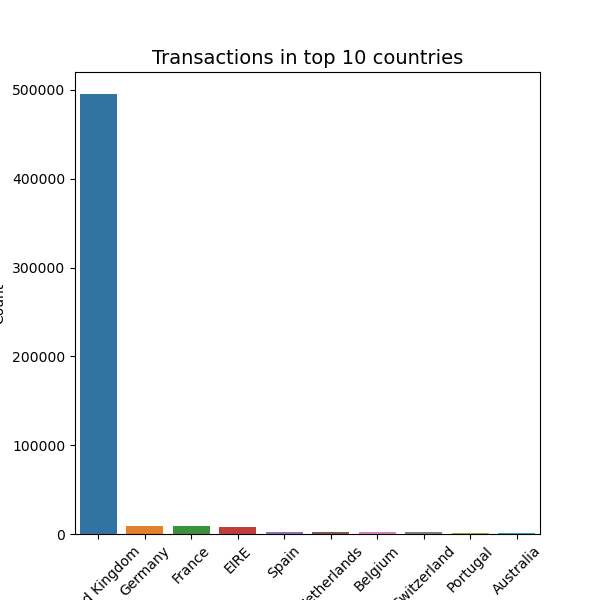

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
country_counts = df_retail['Country'].value_counts()
country_counts=country_counts.reset_index()
country_counts.columns=['Country','Count']
ax=sns.barplot(x='Country', y='Count',data=country_counts.head(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Transactions in top 10 countries', fontsize = 14)
plt.show()

A large majority of orders are from the United Kingdom. Hence, for the purpose of this study, we can safely reject data points belonging to other countries

## Data Preprocessing
**Some insights made so far**:
- There exists 133252 null entries in CustomerID.
- There are 5268 duplicate entries.
- Most of the entries are from the UK.

First, the duplicate entries, entries with Country other than UK and entries with null values for CustomerID will be dropped.

In [7]:
# Removes all duplicates keeping the first instance
df_retail.drop_duplicates(keep='first',inplace=True) 
df_retail.duplicated().sum()

0

In [8]:
# Keeps only entries from the United Kingdom
df_retail=df_retail[df_retail['Country']=='United Kingdom'] 
df_retail['Country'].value_counts()

United Kingdom    490300
Name: Country, dtype: int64

In [9]:
# Drop rows with null entries in CustomerID
df_retail=df_retail.dropna(subset=['CustomerID'])
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356728 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    356728 non-null  object        
 1   StockCode    356728 non-null  object        
 2   Description  356728 non-null  object        
 3   Quantity     356728 non-null  int64         
 4   InvoiceDate  356728 non-null  datetime64[ns]
 5   UnitPrice    356728 non-null  float64       
 6   CustomerID   356728 non-null  float64       
 7   Country      356728 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.5+ MB


In [10]:
df_retail.describe()

,Quantity,UnitPrice,CustomerID
count,356728.000000,356728.000000,356728.000000
mean,11.198644,3.268255,15543.795284
std,264.998044,71.162330,1594.286219
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15513.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


The minimum valuse of quantity and unit price are negative. This is not physically possible and could happen only due to canceled orders. According to the data description, the InvoiceNo of canceled orders contains the letter 'C' in them. These canceled order entries have to be removed to filter out actual transactions.

In [11]:
# removes all cancelled orders
print("The number of canceled orders is : {}".format(df_retail["InvoiceNo"].str.contains("C", na=False)))
df_retail = df_retail[~df_retail["InvoiceNo"].str.contains("C", na=False)] 

The number of canceled orders is : 0         False
1         False
2         False
3         False
4         False
          ...  
541889    False
541890    False
541891    False
541892    False
541893    False
Name: InvoiceNo, Length: 356728, dtype: bool


In [12]:
df_retail.describe()

,Quantity,UnitPrice,CustomerID
count,349227.000000,349227.000000,349227.000000
mean,12.181295,2.972124,15548.333625
std,191.797470,17.990307,1594.403077
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.950000,15518.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,8142.750000,18287.000000


There are still instances of negative values of unit price and quantity. These entries have to be removed.

In [13]:
# Keep only non negative values of Price and Quantity
df_retail = df_retail[(df_retail['UnitPrice']>0) & (df_retail['Quantity']>0)]
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349203 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  float64       
 7   Country      349203 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


## RFM Analysis
For the purpose of clustering, first we have to define Recency, Frequency and Monetary values.
- **Monetary value**- It can be the net amount recieved by the comany from one customer. i.e The sum of quantity times unit price across all transactions of a given customer.
- **Frequency**- This can be defined as the number of purchases made by one customer. i.e the numbver of transactions per customer.
- **Recency**- The time between last transaction and current date. Here, we can assume the most recent transaction date to be the correct date. 


In [14]:
# Calculates amount as product of unit price and Quantity
df_retail['Amount']=df_retail['Quantity']*df_retail['UnitPrice']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [15]:
# Calculates total monetary value of each customers as sum of Amount of all transactions and stores in new dataframe
monetary=df_retail.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33053.19
3,12749.0,4090.88
4,12820.0,942.34


In [16]:
# Total number of individual transaction of customers by invoice number
frequency = df_retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,1
1,12747.0,103
2,12748.0,4412
3,12749.0,199
4,12820.0,59


In [17]:
# Number of days between each transaction and last recorded transaction 
df_retail['Latest'] = max(df_retail['InvoiceDate']) - df_retail['InvoiceDate']
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Latest
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00


In [18]:
# Most recent transaction per customer 
recency = df_retail.groupby('CustomerID')['Latest'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,Latest
0,12346.0,325 days 02:48:00
1,12747.0,1 days 22:15:00
2,12748.0,0 days 00:29:00
3,12749.0,3 days 02:53:00
4,12820.0,2 days 21:37:00


In [19]:
# Remove time from the values
recency['Latest']=recency['Latest'].dt.days
recency.head()

,CustomerID,Latest
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2


In [20]:
# Merge monetary and frequency tables based on CustomerID
rfm = pd.merge(monetary, frequency, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,77183.60,1
1,12747.0,4196.01,103
2,12748.0,33053.19,4412
3,12749.0,4090.88,199
4,12820.0,942.34,59


In [21]:
# Merge monetary and frequency table with recency table based on CustomerID and change column name
rfm = pd.merge(rfm, recency, on='CustomerID', how='inner')
rfm.columns=['CustomerID','Monetary','Frequency','Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,77183.60,1,325
1,12747.0,4196.01,103,1
2,12748.0,33053.19,4412,0
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2


In [22]:
# CustomerID is stored as string
rfm['CustomerID']=rfm['CustomerID'].astype(str)

Now, we have an RFM table. For the next step, we need to remove the outliers. We will use the **z-score** method for the same.

In [23]:
# Statistical description of dataframe
rfm.describe()

,Monetary,Frequency,Recency
count,3920.000000,3920.000000,3920.000000
mean,1858.424654,89.082398,91.208418
std,7478.631256,214.034542,99.533854
min,3.750000,1.000000,0.000000
25%,298.185000,17.000000,17.000000
50%,644.975000,40.000000,50.000000
75%,1571.285000,98.000000,142.000000
max,259657.300000,7676.000000,373.000000


The mean is taken as 0 and standard deviation as 1. We will fit only the values that lie within 3 standard deviations from the mean and remove the rest. This process is repeated for all 3 columns.

In [24]:
# Set upper limit and lower limit at 3 standard deviations from the mean
m_mean=rfm['Monetary'].mean()
m_sd=rfm['Monetary'].std()
upperl_m=m_mean+3*m_sd
lowerl_m=m_mean-3*m_sd
upperl_m,lowerl_m,m_mean,m_sd

(24294.31842285217, -20577.46911468891, 1858.4246540816325, 7478.631256256846)

In [25]:
# Remove outliers
rfm=rfm[(rfm['Monetary']>lowerl_m) & (rfm['Monetary']<upperl_m)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3887.000000,3887.000000,3887.000000
mean,1352.646929,81.866478,91.746077
std,2083.818453,128.558731,99.563190
min,3.750000,1.000000,0.000000
25%,295.465000,16.000000,17.000000
50%,638.050000,40.000000,50.000000
75%,1533.230000,97.000000,143.000000
max,21086.300000,2677.000000,373.000000


In [26]:
# Repeat for frequency
f_mean=rfm['Frequency'].mean()
f_sd=rfm['Frequency'].std()
upperl_f=f_mean+3*f_sd
lowerl_f=f_mean-3*f_sd
upperl_f,lowerl_f,f_mean,f_sd

(467.54267109615193,
 -303.80971508894845,
 81.86647800360176,
 128.55873103085005)

In [27]:
rfm=rfm[(rfm['Frequency']>lowerl_f) & (rfm['Frequency']<upperl_f)] 
rfm.describe()

,Monetary,Frequency,Recency
count,3816.000000,3816.000000,3816.000000
mean,1252.649113,69.819969,93.250262
std,1875.664680,82.122428,99.832045
min,3.750000,1.000000,0.000000
25%,290.390000,16.000000,18.000000
50%,622.130000,39.000000,51.000000
75%,1445.280000,91.000000,147.000000
max,21086.300000,467.000000,373.000000


In [28]:
# Repeat for Recency
r_mean=rfm['Recency'].mean()
r_sd=rfm['Recency'].std()
upperl_r=r_mean+3*r_sd
lowerl_r=r_mean-3*r_sd
upperl_r,lowerl_r,r_mean,r_sd

(392.7463972429747, -206.24587313396, 93.25026205450733, 99.83204506282244)

In [29]:
rfm.info()
rfm.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 1 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3816 non-null   object 
 1   Monetary    3816 non-null   float64
 2   Frequency   3816 non-null   int64  
 3   Recency     3816 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 149.1+ KB


,CustomerID,Monetary,Frequency,Recency
1,12747.0,4196.01,103,1
3,12749.0,4090.88,199,3
4,12820.0,942.34,59,2
5,12821.0,92.72,6,213
6,12822.0,948.88,46,70


## K-Means Clustering

K-Means algorithm assumes symmertical distribution and normalized variables.

- In case the variables are not symmetrically distributed, since all values are positive, we can apply log transformation.
- If the mean and variables are not equal, the variables could be normalized using Min-Max normalization. 

In [30]:
# measure skewness
def skewness_measure(df, column):
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return 

In [31]:
# Plot skewness of all variables
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
skewness_measure(rfm,'Recency')

plt.subplot(3, 1, 2)
skewness_measure(rfm,'Frequency')

plt.subplot(3, 1, 3)
skewness_measure(rfm,'Monetary')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=250)

Recency's: Skew: 1.217276495560285, : SkewtestResult(statistic=24.566687218671124, pvalue=2.8688868188306188e-133)
Frequency's: Skew: 2.139498393651452, : SkewtestResult(statistic=34.93427049128807, pvalue=2.244572451154113e-267)


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

Monetary's: Skew: 4.26118567689371, : SkewtestResult(statistic=48.659926664078775, pvalue=0.0)


In [32]:
#log transformation
rfm_rlog = np.log(rfm['Recency']+0.1) #can't take log(0) and so add a small number
rfm_flog = np.log(rfm['Frequency'])
rfm_mlog = np.log(rfm['Monetary']+0.1)

Now let's plot the skewness after log transform.

In [33]:
log_rfm = pd.DataFrame({'Monetary': rfm_mlog,'Recency': rfm_rlog,'Frequency': rfm_flog})

# Plot skewness of all variables
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
skewness_measure(log_rfm,'Recency')

plt.subplot(3, 1, 2)
skewness_measure(log_rfm,'Frequency')

plt.subplot(3, 1, 3)
skewness_measure(log_rfm,'Monetary')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=250)

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

Recency's: Skew: -1.1882590353698503, : SkewtestResult(statistic=-24.15402941208342, pvalue=6.773102489251262e-129)
Frequency's: Skew: -0.4339450180864357, : SkewtestResult(statistic=-10.507635524591295, pvalue=7.966586177943693e-26)
Monetary's: Skew: 0.05981899692414256, : SkewtestResult(statistic=1.5101877210017653, pvalue=0.13099553096772962)


Now, to standardize the data, we will remove mean and scale to unit variance. 

In [34]:
# Rescaling the attributes
rfm_reshaped = log_rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_reshaped)
rfm_df_scaled.shape

(3816, 3)

In [35]:
# Make dataframe and name colums
rfm_scaled = pd.DataFrame(rfm_df_scaled)
rfm_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_scaled.head()

,Monetary,Frequency,Recency
0,1.622201,0.830796,-2.261574
1,1.600304,1.351598,-1.615766
2,0.333427,0.390170,-1.858524
3,-1.666741,-1.417423,1.021067
4,0.339395,0.193343,0.328045


To find optimum clusters, we will plot the elbow curve and pick the k at the elbow. 

In [36]:
# Calculate SSE to find optimum number of clusters
sse = []
k_rng = range(1,11)
for k in k_rng:
    km = KMeans(n_clusters=k,init='k-means++')
    km.fit(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
    sse.append(km.inertia_)

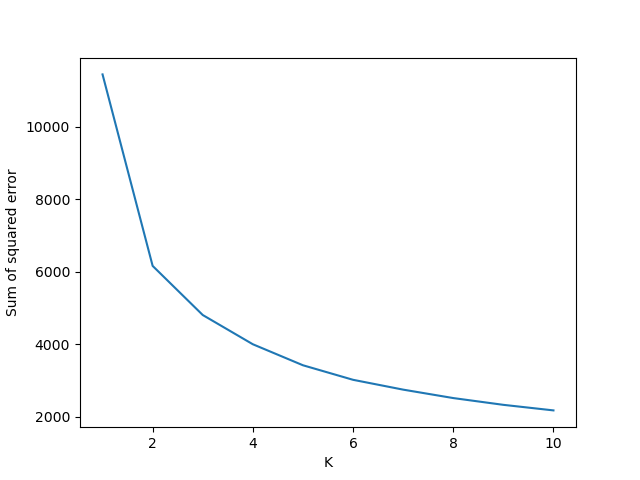

In [37]:
# Plot elbow plot to find k
fig, ax = plt.subplots()
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)
plt.show()

The elbow appears at 2 clusters. So, we will take k=2.

In [38]:
# Perform K-Means clustering on normalized data
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(rfm_scaled[['Monetary', 'Frequency', 'Recency']])
y_predicted

array([0, 0, 0, ..., 1, 1, 0])

In [39]:
# Display cluster centers
km.cluster_centers_

array([[ 0.79848919,  0.79391165, -0.599741  ],
       [-0.67993621, -0.6760383 ,  0.51069649]])

In [40]:
# Add clusters to dataset
rfm_scaled['Cluster']=y_predicted
rfm_scaled.head()

,Monetary,Frequency,Recency,Cluster
0,1.622201,0.830796,-2.261574,0
1,1.600304,1.351598,-1.615766,0
2,0.333427,0.390170,-1.858524,0
3,-1.666741,-1.417423,1.021067,1
4,0.339395,0.193343,0.328045,0


In [41]:
rfm1=rfm_scaled[rfm_scaled['Cluster']==0]
rfm2=rfm_scaled[rfm_scaled['Cluster']==1]

Now, we can plot the clusters we obtained from K-Means clustering.

In [42]:
sns.set(style = "darkgrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(rfm1.Monetary, rfm1.Frequency, rfm1.Recency, c='#58508d', label = 'Cluster 1')
ax.scatter3D(rfm2.Monetary, rfm2.Frequency, rfm2.Recency, c='#bc5090', label = 'Cluster 2')
ax.set_xlabel("Monetary",fontsize=12)
ax.set_ylabel("Frequency",fontsize=12)
ax.set_zlabel("Recency",fontsize=12)
plt.title("RFM",fontsize=18)
plt.legend(bbox_to_anchor=(1.0,1.0),prop={'size': 12})
plt.tight_layout()
plt.savefig('clusters.png', format='png', dpi=250)

## Conclusion

For the purpose of the following analysis, it is safe to assume that there is no correlation between the products bought and the customer cluster. The influence of products and geographical factors can be studied in a different study.

**Some reccomendations**:
- The cancelled orders can all be dealt with uniformly. In this case, while some cancelled orders were represented by the letter 'C' in the invoice number, the others were represented by negative feilds for unit price or quantity.
- Duplicates can be avoided.
- Null entries are to be reevaluated. 